In [58]:
!pip install umap-learn
!pip install pointgrid

In [73]:
import torch
from torch import nn
from torch.utils.data import Dataset
import torch.nn.functional as F

from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.io import read_image
from torchvision.transforms import v2
from torchvision.io import decode_image

from pointgrid import align_points_to_grid
import umap

import matplotlib.pyplot as plt
import numpy as np

import os
import pandas as pd
import random
import json


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [74]:

class ContrastiveDataset(Dataset):


    def __init__(self, indexes_to_groups,group_paris,img_dir,transform=None, rand_state=12):

        self.rand_state = rand_state
        self.transform = transform
        self.img_dir = img_dir

        with open(indexes_to_groups) as f1:
            self.idd = json.loads(f1.read())

        with open(group_paris) as f2:
            self.gpd = json.loads(f2.read())

        self.train_list = []

        ## ADD shuffle

        for index,val in self.idd.items():

            v = self.gpd[str(val)]
            ind = int(index)

            random.seed(2)

            for p in v[0][:10]:
                self.train_list.append((ind,p,1))
            for n in random.sample(v[1],10):
                self.train_list.append((ind,n,0))


    def __len__(self):
        return len(self.train_list)


    def __getitem__(self, index):

        (anchor,other,score) = self.train_list[index]

        anchor_image = read_image(os.path.join(self.img_dir, f'{anchor}.jpg'))
        other_image = read_image(os.path.join(self.img_dir, f'{other}.jpg'))


        if self.transform:
            anchor_image = self.transform(anchor_image)
            other_image = self.transform(other_image)


        return (anchor_image,other_image,score)

In [75]:
pg = '/content/drive/MyDrive/ADLData/pairs_groups.json'
itg = '/content/style_sample_indexes_to_groups.json'
im_dir = '/content/drive/MyDrive/ADLData/image_data'

In [76]:
transformer_pipe = v2.Compose([
    v2.Resize((224,224)),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [77]:
CDS = ContrastiveDataset(itg,pg,im_dir,transform=transformer_pipe,rand_state=1000)

In [78]:
model = torch.load('model', weights_only=False)

In [79]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [80]:
model.to(device)
model.eval()

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_

In [81]:
all = list(set([ x[0] for x in CDS.train_list  ]))

In [82]:
alls = random.sample(all,500)

In [83]:
res = []
id = []
for x in alls[:100]:
  img  = decode_image(im_dir+f"/{x}.jpg")

  # Step 3: Apply inference preprocessing transforms
  batch = transformer_pipe(img).unsqueeze(0)


  batch = batch.to(device)

  # Step 4: Use the model and print the predicted category
  prediction_c = model(batch).squeeze(0).softmax(0)

  res.append(prediction_c)
  id.append(x)


In [84]:
resc = [x.cpu().detach().numpy() for x in res]

In [85]:
resc = np.array(resc)

In [115]:
reducer = umap.UMAP(random_state=2, n_components=2, n_neighbors=2, min_dist=0.0, metric='euclidean')
# reducer = umap.UMAP(random_state=2, n_components=2, n_neighbors=2, min_dist=0.01, metric='hellinger')

embedding = reducer.fit_transform(resc)
embedding = align_points_to_grid(embedding)

x = embedding[:, 0]
y = embedding[:, 1]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [88]:
df = pd.read_csv('art_data_loaded.csv')

In [89]:
topc = []
name = []
for x in id:
  row = df.loc[df['index'] == x]
  row['title']
  row['style']
  topc.append(row['style'].values[0])
  name.append(row['title'].values[0])

In [90]:
maping = {'Art Nouveau':1,
 'Baroque':2,
 'Early Renaissance':3,
 'High Renaissance':4,
 'Impressionism':5,
 'Mannerism':6,
 'Medieval':7,
 'Neoclassicism':8,
 'Northern Renaissance':9,
 'Realism':10,
 'Rococo':11,
 'Romanticism':13}

In [91]:
topcn = [maping[x] for x in topc]

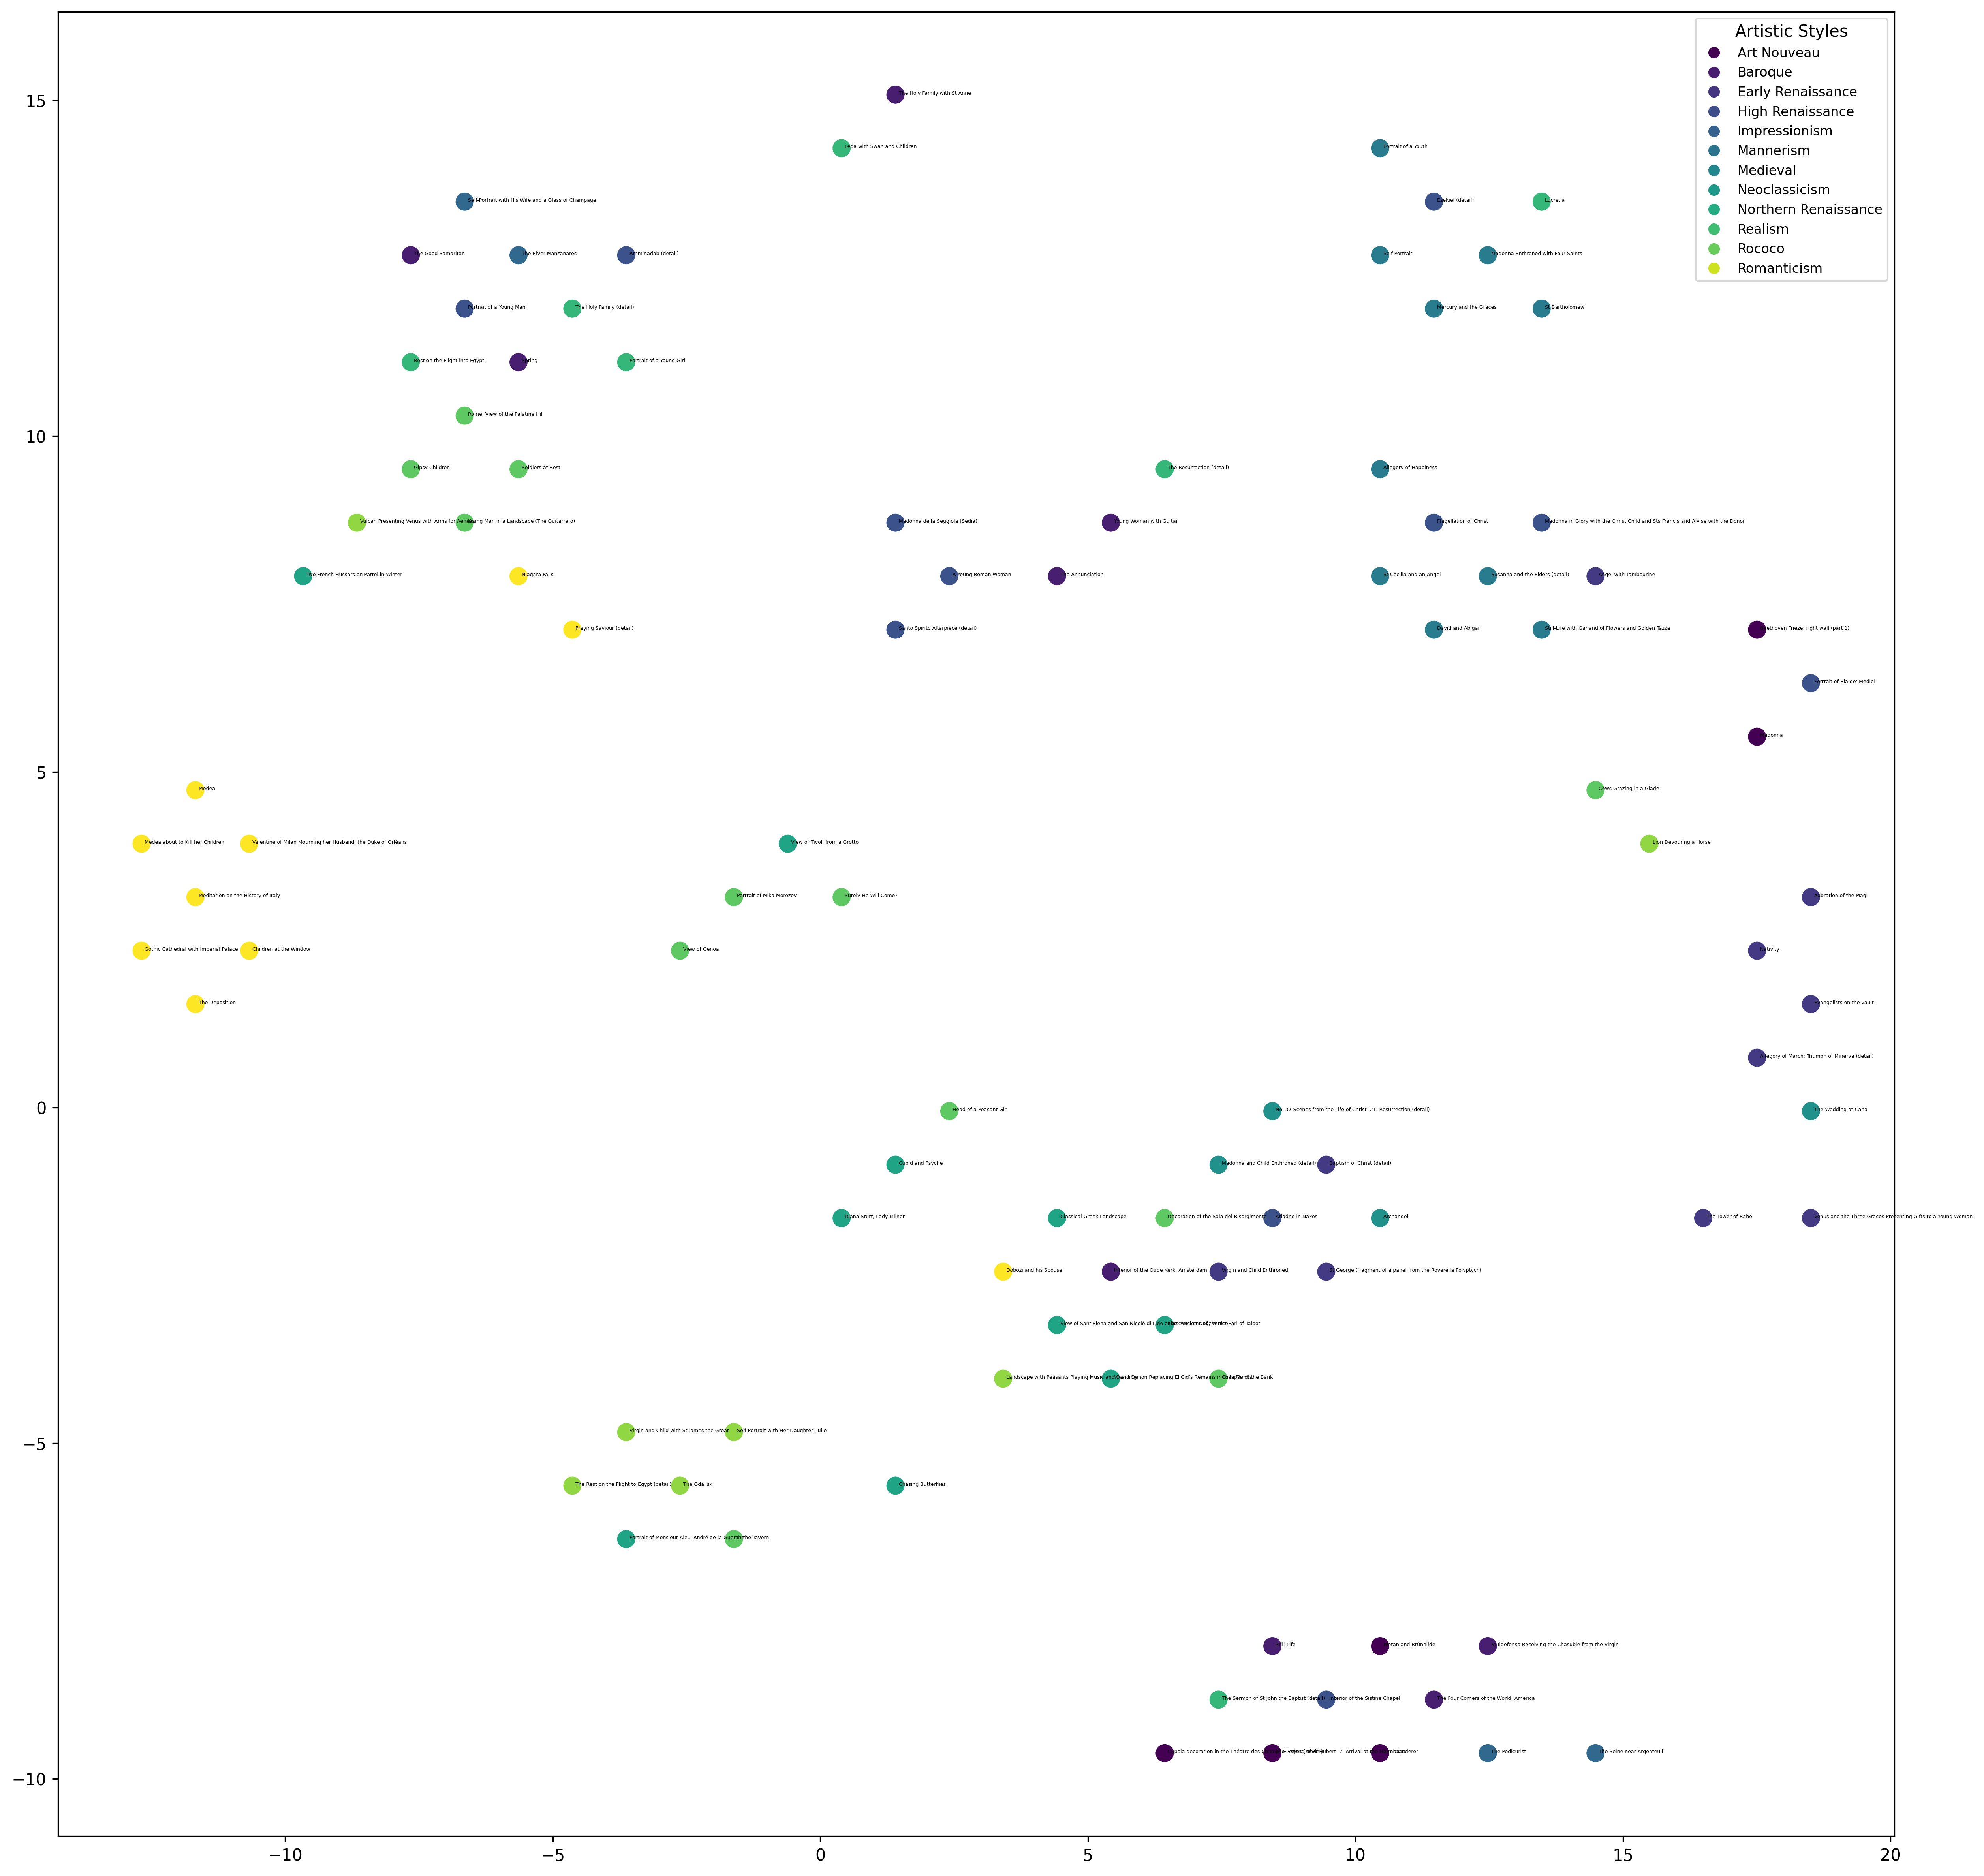

In [116]:
plt.figure(figsize=(20,20), dpi=300)
plt.scatter(x, y, s=100,c=topcn)

legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                              label=style,
                              markerfacecolor=plt.cm.viridis((value-1)/13), markersize=8)
                   for style, value in maping.items()]

plt.legend(handles=legend_elements, title="Artistic Styles", loc="upper right", fontsize=8, title_fontsize=10)

for i, txt in enumerate(name):
    text = plt.annotate(' ' + name[i], (x[i] + .03, y[i]))
    text.set_fontsize(3)